In [1]:
# written by Mahad 
# edited by Tanvi Deora on Oct 2
# This code calculates tortoiusity in two ways - 
# 1) displacement over distance measure
# 2) spectral analysis (frequency) of the tracks. 

In [1]:
from matplotlib import pyplot as plt
# from matplotlib import style
# style.use('seaborn-talk')
# from matplotlib import cm
import numpy as np
import os
# import scipy.io
# import seaborn as sb
from scipy.fftpack import fft
# import csv
import pandas as pd
# from scipy.signal import butter, filtfilt
import glob

from scipy import stats
from scipy import signal
from statsmodels.graphics.gofplots import qqplot, qqline
# sns.set(style="ticks")

# load the centroid data

In [4]:
# get centroid data 
Centroids = pd.read_csv(r"./dataFolders/Output/KinematicAnalysis_v5/CentroidAndDistanceData.csv")
Centroids = Centroids.drop(columns = ['Unnamed: 0' , 'Unnamed: 0.1'])
Centroids[['lightLevel', 'mothID']] = Centroids.name.str.split('_', n = 1, expand = True )
Centroids.head()

,name,visit,flower_r,flower_x,flower_y,x,y,x_pixel,y_pixel,x_smoothened,y_smoothened,cent_x,cent_y,distance,distanceincms,lightLevel,mothID
0,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L0.1,c-3_m10
1,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L0.1,c-3_m10
2,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L0.1,c-3_m10
3,L0.1_c-3_m10,last,74,310,233,0.810811,2.297297,24.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN,L0.1,c-3_m10
4,L0.1_c-3_m10,last,74,310,233,1.013514,2.770270,30.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,L0.1,c-3_m10


In [5]:
# remove Problematic Files

listProbs = pd.read_csv(r'G:\My Drive\Mahad\Light Level Experiments\Data Output from Analysis\VideosWithMarkers\FirstLastTroubleVideos_v4\names.csv')
listProbs['name'] = listProbs['name'].str[1:]
listProbs.head()

Centroids['string'] = Centroids.name + '_' + Centroids.visit + 'Visit.csv'

sub_Centroids= Centroids[pd.DataFrame(Centroids.string.tolist()).isin(listProbs.name.tolist()).any(1) == False]
sub_Centroids= sub_Centroids.drop(columns = 'string')

# get the tortuosity measurements

In [209]:
def GetStartStopFrame(x):
    m = np.concatenate(( [True], np.isnan(x), [True] ))  # Mask
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits
    start,stop = ss[(ss[:,1] - ss[:,0]).argmax()]  # Get max interval, interval limits
    return start, stop

In [7]:
def GetLongestFinitePath(x,y):
    ind_s_x, ind_stp_x = GetStartStopFrame(x)
    ind_s_y, ind_stp_y = GetStartStopFrame(y)
    
    strt = max([ind_s_x, ind_s_y])
    stp = min([ind_stp_x, ind_stp_y])
    
    new_x = x[strt: stp]
    new_y = y[strt: stp]
    return new_x, new_y

In [8]:
def Tortuosity(x, time):
    
    t = time/100 # filmed at 100 fps
    Nx = len(x)  #number of points
    Nt = Nx
    Time = t[-1]-t[0]   #total sample time (in seconds)
    fs = Nx/Time   # sample frequency
    TT = 1/fs  #delta t.
 
    meanx = np.mean(x)
    
    #fftxvel is complex with real and imaginary part.
    #Nyquist spacing (first half of Fourier) -- the list of frequencies for which we have Fourier coefficients
    fftx = fft(x-meanx) 
    xf = np.linspace(0.0, 1.0/(2.0*TT), Nx//2)  

    return xf, Nx, fftx

In [9]:
def fullDistance(x, y):
    distance = 0
    for i in np.arange(len(x)-1):
        d = np.sqrt((x[i+1] - x[i])**2 + (y[i+1] - y[i])**2)
        distance+=d
    return distance

In [10]:
chunksize = 40 # number of frames in each chunck

### loop through data 

In [212]:
# all_dfs = pd.DataFrame(data = None)
all_dfs = []

for v, df in sub_Centroids.groupby('visit'):
    for l, sub_df in df.groupby('lightLevel'):
        for m, final_df in sub_df.groupby('mothID'):
#             final_df.reindex()
            
            x = final_df.x_smoothened.values
            y = final_df.y_smoothened.values

            # get the longest section without NaNs
            new_x, new_y = GetLongestFinitePath(x,y)
            if not new_x.size:
                print('%s in %s visit and %s has path length of %i' %(m,v,l, len(new_x)))
                continue
            
            # get the x, y coordinates and frame number of each track
            x = new_x
            y = new_y
            time = np.arange(0,len(x)-1, 1)
            
            # chunk the data 
            Displ_tor = []
            fft_amplitude = []

            visit = []
            lightLevel = []
            mothID = []
            
            # do analysis on a sliding window of chunksize
            for idx in np.arange(0,len(x)-chunksize, 1):
                
                chunk_x = x[idx: idx+chunksize]
                chunk_y = y[idx: idx+chunksize]
                chunk_time = time[idx: idx+chunksize]
                
                # Method 1: Distance/displacement
                # the net displacement of the track  
                shortest_path = np.sqrt((chunk_x[-1]- chunk_x[0])**2 \
                                        + (chunk_y[-1]- chunk_y[0])**2) 
                dist = fullDistance(chunk_x, chunk_y)

                # caluclate the path distance ratio
                ratio = dist/shortest_path 
                Displ_tor.append(ratio)

                # Method 2: Spectral analysis   
                xf, Nx, fftx = Tortuosity(chunk_x, chunk_time)
#                 print(xf)
                yf, Ny, ffty = Tortuosity(chunk_y, chunk_time)
                # linear sum of the x and y coordinates amplitude of fft
                sum_xy = ((2.0/Ny * np.abs(ffty[0:Ny//2])) + (2.0/Nx * np.abs(fftx[0:Nx//2])))

                fft_amplitude.append(sum_xy)
            
            length = len(x) - chunksize #fill in other deets about this moth
            visit.extend([v]*length)
            mothID.extend([m]*length)
            lightLevel.extend([l]*length)
            
            df1 = pd.DataFrame({'visit': visit,
                   'mothID': mothID,
                   'lightLevel': lightLevel,
                   'Displacement_tor': Displ_tor})
            
            df2 = pd.DataFrame(data = fft_amplitude, columns = np.round(xf, 3))
            df = pd.concat([df1, df2], axis = 1)
            all_dfs.append(df)

In [213]:
# concatenate all dfs together into one single big df
full_df = pd.concat(all_dfs)
#                     , sort = True)
full_df.to_csv('./dataFolders/Output/KinematicAnalysis_v5/TortousityData_Full.csv')

In [248]:
# get averages for each visit
visit = []
light = []
moth = []
disp = []
fft = []

for v, bla in full_df.groupby('visit'):
    for l, blu in bla.groupby('lightLevel'):
        for m, blum in blu.groupby('mothID'):
            disp_tor = blum.Displacement_tor.median()
            left_over = blum.drop(columns = ['visit', 'lightLevel', 'mothID', 'Displacement_tor'])
            med_fft = left_over.median()
            
            visit.append(v)
            light.append(l)
            moth.append(m)
            disp.append(disp_tor)
            fft.append(med_fft)
            
rest_df = pd.DataFrame({'visit': visit, 
                       'lightLevel': light,
                       'mothID': moth,
                       'disp_tor': disp})
med_fft = pd.concat(fft, axis = 1)
med_fft.T

med_df = pd.concat([rest_df, med_fft.T], axis = 1)

In [250]:
med_df.to_csv('./dataFolders/Output/KinematicAnalysis_v5/TortousityData_median.csv')

# plot the tortuosity

In [31]:
import seaborn as sns
from scipy import stats

In [25]:
# Pathways
figpath = r"./dataFolders/Output/KinematicAnalysis_v5/Figures/Tortuosity/"

In [3]:
data = pd.read_csv('./dataFolders/Output/KinematicAnalysis_v5/TortousityData_median.csv')
data.head()

,Unnamed: 0,visit,lightLevel,mothID,disp_tor,0.0,2.699,5.398,8.097,10.796,...,26.991,29.69,32.389,35.088,37.787,40.486,43.185,45.884,48.583,51.282
0,0,first,L0.1,c-3_m2,2.908081,7.105427e-14,28.024076,11.757016,7.371169,5.404669,...,4.595411,2.778010,2.013103,1.867771,1.763532,1.668547,1.617313,1.585648,1.601730,1.738399
1,1,first,L0.1,c-3_m20,3.201427,4.405365e-14,31.786532,13.072989,8.869383,7.006051,...,3.738729,2.801349,2.397501,2.316112,2.177401,2.108492,1.972797,1.858891,1.908800,2.008177
2,2,first,L0.1,c-3_m21,2.664196,4.050094e-14,45.462987,16.987136,10.858711,8.018155,...,4.158650,3.486046,2.998915,2.790844,2.695274,2.566967,2.480812,2.448928,2.437468,2.392144
3,3,first,L0.1,c-3_m22,2.742491,4.973799e-14,43.714187,21.512413,14.156056,10.517293,...,5.484095,3.888987,3.633352,3.516173,3.345746,3.185143,3.111546,3.003325,3.061593,3.211196
4,4,first,L0.1,c-3_m23,2.792891,2.522427e-14,41.083758,15.037663,9.823523,7.470665,...,4.459521,3.043988,2.586532,2.464322,2.337013,2.221975,2.132730,2.112731,2.045236,2.819273


In [5]:
w = 7/3
# w = 8
h = w * 2

## path length method

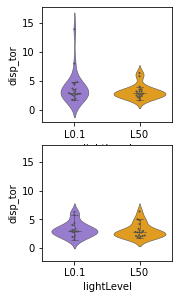

In [26]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0

for v, sub in data.groupby('visit'):
    sns.violinplot(x='lightLevel', y='disp_tor', data = sub, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='disp_tor', data = sub, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
    sns.swarmplot(x='lightLevel', y='disp_tor', data = sub,
                size=2, 
                  color="0.3",
                  linewidth=0,
                  ax=ax[i])
    i+=1
plt.savefig(figpath + 'Displacement-tor.pdf')

In [28]:
low_first = data[(data.lightLevel == 'L0.1') & (data.visit == 'first')].disp_tor.values
high_first = data[(data.lightLevel == 'L50') & (data.visit == 'first')].disp_tor.values

low_last = data[(data.lightLevel == 'L0.1') & (data.visit == 'last')].disp_tor.values
high_last = data[(data.lightLevel == 'L50') & (data.visit == 'last')].disp_tor.values

In [29]:
stats.mannwhitneyu(low_first, high_first)

MannwhitneyuResult(statistic=160.0, pvalue=0.21101726745656363)

In [30]:
stats.mannwhitneyu(low_last, high_last)

MannwhitneyuResult(statistic=130.0, pvalue=0.22885871721372308)

## fft tortuosity

In [17]:
test = data.drop(columns = ['Unnamed: 0', 'visit', 'lightLevel', 'mothID', 'disp_tor'])

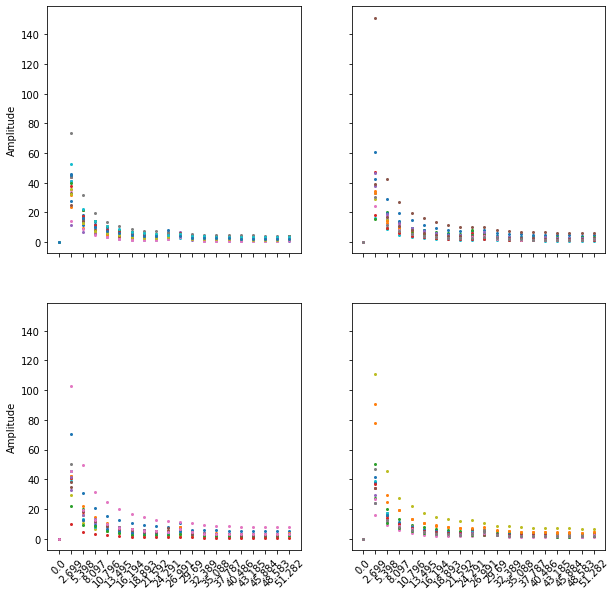

In [50]:
f,ax = plt.subplots(2,2, figsize = (10,10), sharex = True, sharey = True)
ax = ax.ravel()

i = 0
for v, sub in data.groupby('visit'):
    for l, subsub in sub.groupby('lightLevel'):
        test = subsub.drop(columns = ['Unnamed: 0', 'visit', 'lightLevel', 'mothID', 'disp_tor'])
        for index, row in test.iterrows():
            ax[i].plot(row.index, row.values, 'o'
                      , markersize = 2)
        i+=1

for axis in [ax[2], ax[3]]:
    plt.setp(axis.xaxis.get_majorticklabels(), rotation=45)
for axis in [ax[0], ax[2]]:
    axis.set_ylabel('Amplitude')
#     text(-0.1, 0.5, 'Amplitude', horizontalalignment='center',
#              verticalalignment='center', 
#              rotation=90,
#              transform=axis.transAxes,
#             fontsize = 12)
plt.savefig(figpath + 'fft_rawData.pdf')

In [66]:
low = row.index[1:5]
medium = row.index[5:9]
high = row.index[11:]
low, medium, high

(Index(['2.699', '5.398', '8.097', '10.796'], dtype='object'),
 Index(['13.495', '16.194', '18.893', '21.592'], dtype='object'),
 Index(['29.69', '32.389', '35.088', '37.787', '40.486', '43.185', '45.884',
        '48.583', '51.282'],
       dtype='object'))

In [94]:
low_val = []
med_val = []
high_val = []
visit_l = []
visit_m = []
visit_h = []
lightLevel_l = []
lightLevel_m = []
lightLevel_h = []

for v, sub in data.groupby('visit'):
    for l, subsub in sub.groupby('lightLevel'):
        test = subsub.drop(columns = ['Unnamed: 0', 'visit', 'lightLevel', 'mothID', 'disp_tor'])
        low_freq = list(test.iloc[:,1:5].values.ravel())
        med_freq = list(test.iloc[:,5:9].values.ravel())
        high_freq = list(test.iloc[:,11:].values.ravel())
        
        low_val.extend(low_freq)
        med_val.extend(med_freq)
        high_val.extend(high_freq)
        
        visit_l.extend([v]*len(low_freq))
        lightLevel_l.extend([l]*len(low_freq))
        
        visit_m.extend([v]*len(med_freq))
        lightLevel_m.extend([l]*len(med_freq))
        
        visit_h.extend([v]*len(high_freq))
        lightLevel_h.extend([l]*len(high_freq))

In [101]:
low_fft = pd.DataFrame({'visit' : visit_l,
                    'lightLevel': lightLevel_l,
                    'spectraAmplitude': low_val})

med_fft = pd.DataFrame({'visit' : visit_m,
                    'lightLevel': lightLevel_m,
                    'spectraAmplitude': med_val})

high_fft = pd.DataFrame({'visit' : visit_h,
                    'lightLevel': lightLevel_h,
                    'spectraAmplitude': high_val})

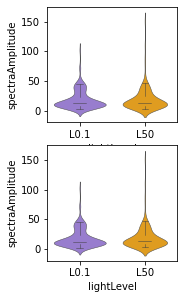

In [113]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0

for v, sub in data.groupby('visit'):
    sns.violinplot(x='lightLevel', y='spectraAmplitude', data = low_fft, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='spectraAmplitude', data = low_fft, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
#     sns.swarmplot(x='lightLevel', y='spectraAmplitude', data = low_fft,
#                 size=2, 
#                   color="0.3",
#                   linewidth=0,
#                   ax=ax[i])
    i+=1
plt.savefig(figpath + 'fft_low.pdf', bbox_inches = 'tight',
    pad_inches = 0)

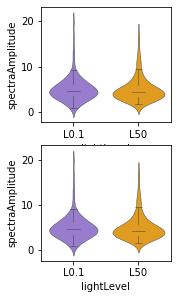

In [114]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0

for v, sub in data.groupby('visit'):
    sns.violinplot(x='lightLevel', y='spectraAmplitude', data = med_fft, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='spectraAmplitude', data = med_fft, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
#     sns.swarmplot(x='lightLevel', y='spectraAmplitude', data = low_fft,
#                 size=2, 
#                   color="0.3",
#                   linewidth=0,
#                   ax=ax[i])
    i+=1
plt.savefig(figpath + 'fft_med.pdf', bbox_inches = 'tight',
    pad_inches = 0)

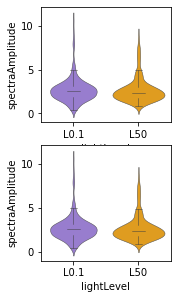

In [115]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0

for v, sub in data.groupby('visit'):
    sns.violinplot(x='lightLevel', y='spectraAmplitude', data = high_fft, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='spectraAmplitude', data = high_fft, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
#     sns.swarmplot(x='lightLevel', y='spectraAmplitude', data = low_fft,
#                 size=2, 
#                   color="0.3",
#                   linewidth=0,
#                   ax=ax[i])
    i+=1
plt.savefig(figpath + 'fft_high.pdf', bbox_inches = 'tight',
    pad_inches = 0)

In [111]:
string = ['low', 'med', 'high']
for data, s in zip([low_fft, med_fft, high_fft], string):
    low_first = data[(data.lightLevel == 'L0.1') & (data.visit == 'first')].spectraAmplitude.values
    high_first = data[(data.lightLevel == 'L50') & (data.visit == 'first')].spectraAmplitude.values

    low_last = data[(data.lightLevel == 'L0.1') & (data.visit == 'last')].spectraAmplitude.values
    high_last = data[(data.lightLevel == 'L50') & (data.visit == 'last')].spectraAmplitude.values
    
    print(s)
    print('first visit')
    print(stats.mannwhitneyu(low_first, high_first))
    print('last visit')
    print(stats.mannwhitneyu(low_last, high_last))

low
first visit
MannwhitneyuResult(statistic=2941.0, pvalue=0.3846524164670462)
last visit
MannwhitneyuResult(statistic=2334.0, pvalue=0.31803078426340425)
med
first visit
MannwhitneyuResult(statistic=2993.0, pvalue=0.4568287592698539)
last visit
MannwhitneyuResult(statistic=2120.0, pvalue=0.08605787096631057)
high
first visit
MannwhitneyuResult(statistic=15221.0, pvalue=0.46321825622453927)
last visit
MannwhitneyuResult(statistic=10380.0, pvalue=0.006368586973035046)


In [13]:
# these FFTs are for the entire visit
xf, N_x, fft_x = Tortuosity(x, time)
yf, N_y, fft_y = Tortuosity(y, time)
# linear addition of the x and y axis fft.
# 2/N_ * abs(fft_) scales the fft amplitudes from the previous line 
sum_ = ((2.0/N_y * np.abs(fft_y[0:N_y//2])) + (2.0/N_x * np.abs(fft_x[0:N_x//2]))) 

In [64]:
len(mean_list),len(std_list), len(name_list), len(visit_list), len(fh_means), len(sh_means), len(fh_means), len(fh_stds), len(sh_stds)

(613, 613, 613, 110, 613, 613, 613, 613, 613)

In [68]:
new_df = (pd.DataFrame({'name' : name_list, 
                        'std_tortuosity': std_list, 'mean_tortuosity' : mean_list, 
                        'first_mean_amplitude': fh_means, 'second_mean_amplitude': sh_means, 
                        'first_part2_mean_amplitude': fsh_means,
                        'condition': condition}))
new_df = new_df.sort_values(by=['name'])
new_df.reset_index(drop=True, inplace=True)
new_df.to_csv(figpath + "\\tortuosity_values_v3.csv")

In [69]:
new_df = pd.read_csv(figpath + "\\tortuosity_values_v3.csv")

In [31]:
new_df_first = new_df[new_df.visit_number == 'F']
new_df_last = new_df[new_df.visit_number == 'L']

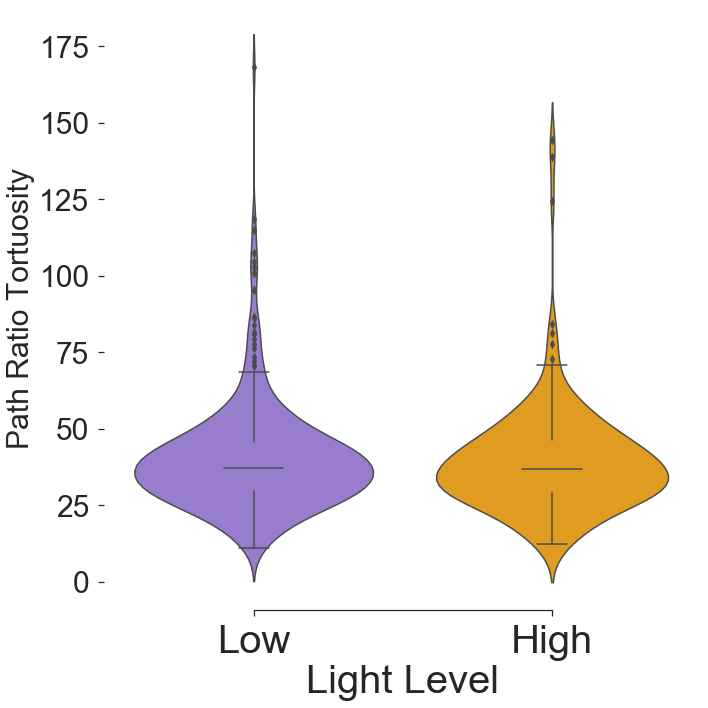

In [70]:
#I think for these guys wing beat becomes important b/c it drives the centroid moving
#need to add the original values to ground these comparisons
f, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(x="condition", y="mean_tortuosity",
                    data= new_df, inner = None,  palette=['mediumpurple','orange'])
sns.boxplot(x="condition", y="mean_tortuosity",
                    data=new_df, width = 0.2)
for tick in ax.get_yticklabels():
    tick.set_fontsize(30) 
ax.xaxis.grid(False)
ax.set_ylabel("Path Ratio Tortuosity", size = 30)
ax.set_xlabel("Light Level", size = 40)
ax.set_xticklabels(["Low","High"], size = 40)
sns.despine(trim=True, left=True)
plt.tight_layout()
# plt.savefig(figpath + "/path_ratio_tortuosity_last.png")

In [33]:
low = new_df_first[new_df_first.condition == "Low"].mean_tortuosity.values
high = new_df_first[new_df_first.condition == "High"].mean_tortuosity.values

In [34]:
low_ = new_df_last[new_df_last.condition == "Low"].mean_tortuosity.values
high_ = new_df_last[new_df_last.condition == "High"].mean_tortuosity.values

(<Figure size 748.8x514.8 with 1 Axes>, <Figure size 748.8x514.8 with 1 Axes>)

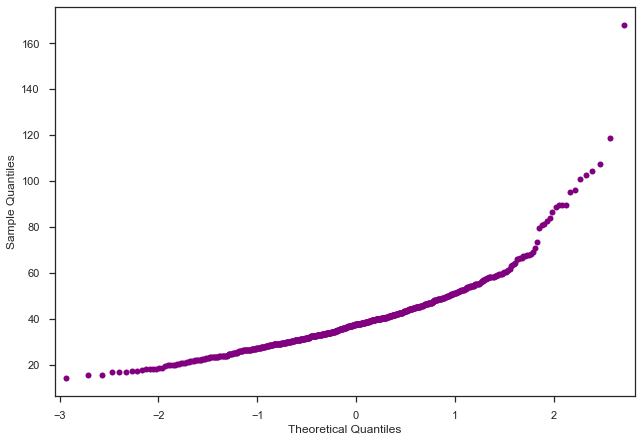

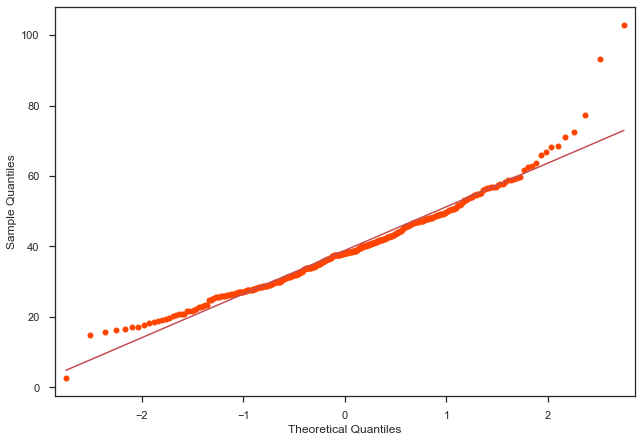

In [45]:
qqplot(low, line='s', c = "purple"), qqplot(high, line='s', c = "orangered")

C:\Users\guess\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\guess\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\guess\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\guess\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(Ks_2sampResult(statistic=0.20954907161803712, pvalue=0.4925026951995167),
 MannwhitneyuResult(statistic=373.0, pvalue=0.4764745948900613))

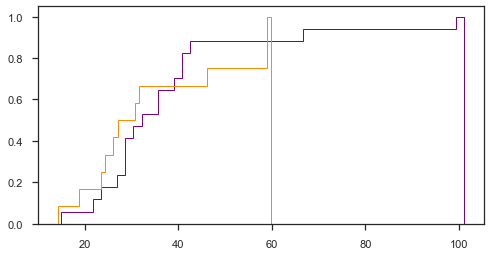

In [36]:
#this method assumes each data point is independent. However, even under this assumption there are no significant differences 
n_bins = 50
fig, ax = plt.subplots(figsize=(8, 4))
n, bins, patches = ax.hist(low, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical', color = 'purple')
n, bins, patches = ax.hist(high, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical', color = 'darkorange')
stats.ks_2samp(low, high), stats.mannwhitneyu(low, high)

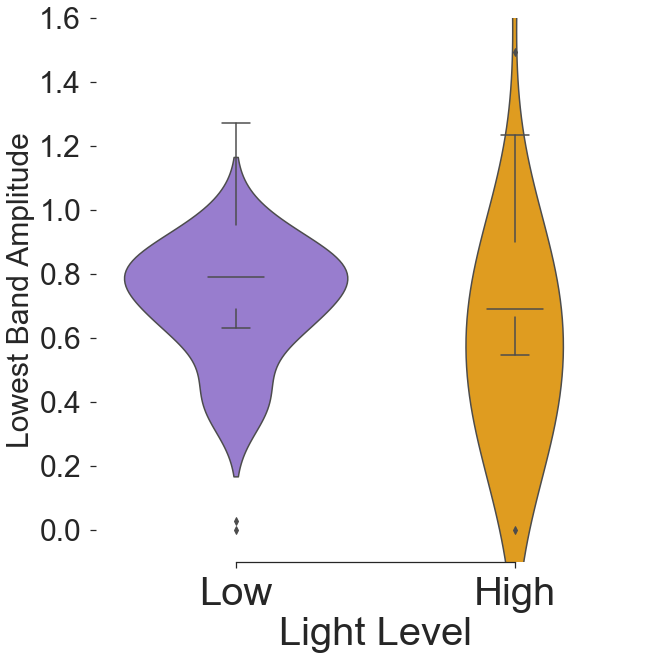

In [38]:
#need to add the original values to ground these comparisons
f, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(x="condition", y="first_mean_amplitude",
                    data= new_df_first, inner = None,  palette=['mediumpurple','orange'])
sns.boxplot(x="condition", y="first_mean_amplitude",
                    data=new_df_last, width = .2)
ax.set_ylim(-0.1,1.6)

for tick in ax.get_yticklabels():
    tick.set_fontsize(30) 
ax.xaxis.grid(False)
ax.set_ylabel("Lowest Band Amplitude", size = 30)
ax.set_xlabel("Light Level", size = 40)
ax.set_xticklabels(["Low","High"], size = 40)
sns.despine(trim=True, left=True)
# plt.savefig(figpath + "/low_band_amplitude_last.png")

In [72]:
#this method assumes each data point is independent. However, even under this assumption there are no significant differences 
s_f_amplitude = new_df[new_df.condition == "Low"].first_mean_amplitude.values
e_f_amplitude = new_df[new_df.condition == "High"].first_mean_amplitude.values
stats.ks_2samp(s_f_amplitude, e_f_amplitude), stats.mannwhitneyu(s_f_amplitude, e_f_amplitude)

(Ks_2sampResult(statistic=0.14396165687097678, pvalue=0.005309147493650523),
 MannwhitneyuResult(statistic=38637.0, pvalue=0.021512422504046568))

In [40]:
#this method assumes each data point is independent. However, even under this assumption there are no significant differences 
s_f_ = new_df_last[new_df_last.condition == "Low"].first_mean_amplitude.values
e_f_ = new_df_last[new_df_last.condition == "High"].first_mean_amplitude.values
stats.ks_2samp(s_f_, e_f_), stats.mannwhitneyu(s_f_, e_f_)

(Ks_2sampResult(statistic=0.23209549071618038, pvalue=0.37992954931533984),
 MannwhitneyuResult(statistic=361.5, pvalue=0.4001814744372808))

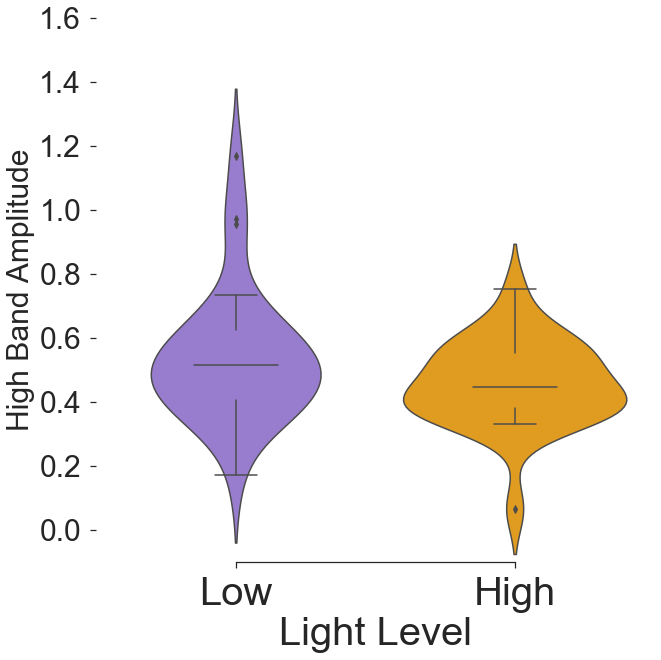

In [45]:
#need to add the original values to ground these comparisons
f, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(x="condition", y="second_mean_amplitude",
                    data= new_df_last, inner = None,  palette=['mediumpurple','orange'])
sns.boxplot(x="condition", y="second_mean_amplitude",
                    data=new_df_last, width = .3)
ax.set_ylim(-0.1,1.6)

for tick in ax.get_yticklabels():
    tick.set_fontsize(30) 
ax.xaxis.grid(False)
ax.set_ylabel("High Band Amplitude", size = 30)
ax.set_xlabel("Light Level", size = 40)
ax.set_xticklabels(["Low","High"], size = 40)
sns.despine(trim=True, left=True)
plt.savefig(figpath + "/high_band_amplitude_last.png")

In [45]:
#this method assumes each data point is independent. However, even under this assumption there are no significant differences 
s_s_amplitude = new_df_first[new_df_first.condition == "Low"].second_mean_amplitude.values
e_s_amplitude = new_df_first[new_df_first.condition == "High"].second_mean_amplitude.values
stats.mannwhitneyu(s_s_amplitude, e_s_amplitude)

MannwhitneyuResult(statistic=368.0, pvalue=0.4430287552735178)

In [46]:
s_s_ = new_df_last[new_df_last.condition == "Low"].second_mean_amplitude.values
e_s_ = new_df_last[new_df_last.condition == "High"].second_mean_amplitude.values
stats.mannwhitneyu(s_s_, e_s_)

MannwhitneyuResult(statistic=355.5, pvalue=0.3616588112261996)

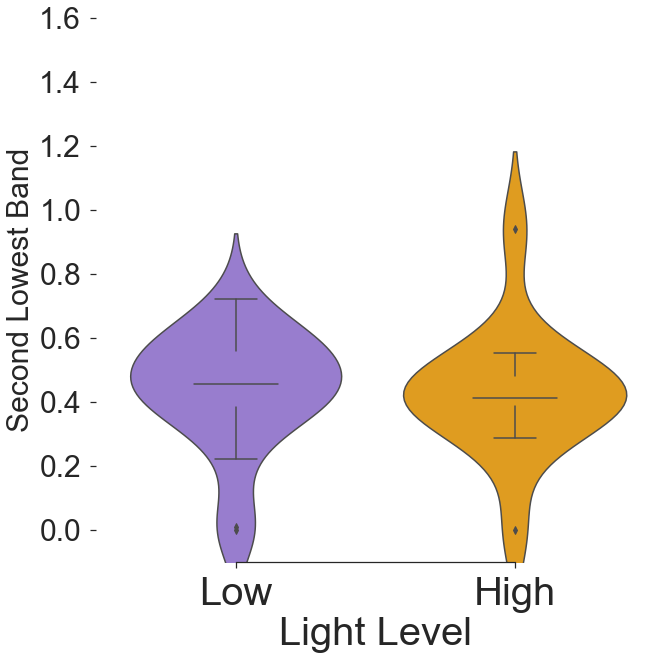

In [48]:
#need to add the original values to ground these comparisons
f, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(x="condition", y="first_part2_mean_amplitude",
                    data= new_df_last, inner = None,  palette=['mediumpurple','orange'])
sns.boxplot(x="condition", y="first_part2_mean_amplitude",
                    data= new_df_last, width = .3)

ax.set_ylim(-0.1,1.6)
for tick in ax.get_yticklabels():
    tick.set_fontsize(30) 
ax.xaxis.grid(False)
ax.set_ylabel("Second Lowest Band", size = 30)
ax.set_xlabel("Light Level", size = 40)
ax.set_xticklabels(["Low","High"], size = 40)
sns.despine(trim=True, left=True)

plt.savefig(figpath + "\second_lowest_band_last.png")

In [49]:
#this method assumes each data point is independent. However, even under this assumption there are no significant differences 
s_fv_amplitude = new_df_first[new_df_first.condition == "Low"].first_part2_mean_amplitude.values
e_fv_amplitude = new_df_first[new_df_first.condition == "High"].first_part2_mean_amplitude.values
stats.mannwhitneyu(s_fv_amplitude, e_fv_amplitude)

MannwhitneyuResult(statistic=339.0, pvalue=0.26363394172363763)

In [50]:
#this method assumes each data point is independent. However, even under this assumption there are no significant differences 
s_fv_ = new_df_last[new_df_last.condition == "Low"].first_part2_mean_amplitude.values
e_fv_ = new_df_last[new_df_last.condition == "High"].first_part2_mean_amplitude.values
stats.mannwhitneyu(s_fv_, e_fv_)

MannwhitneyuResult(statistic=362.5, pvalue=0.406708997099042)